In [1]:
%load_ext autoreload
%aimport utils.text_processing
%autoreload 1

In [2]:
from datasets import load_dataset
from datasets import Dataset

from utils.text_processing import TextProcessor

from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from sklearn.model_selection import train_test_split
from transformers import DataCollatorForSeq2Seq
from transformers import AutoTokenizer

import pandas as pd
import numpy as np
import evaluate

/home/marwan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-24 20:14:38.994145: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 20:14:38.994204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 20:14:39.039323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 20:14:39.122519: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is opti

In [3]:
dataset = load_dataset("Nicolas-BZRD/Parallel_Global_Voices_English_French", split='train').to_pandas()

dataset['en'] = TextProcessor(dataset, 'en').transform()
dataset['fr'] = TextProcessor(dataset, 'fr').transform()

dataset.head(10)

,en,fr
0,<start> jamaica i am hiv <end>,<start> jamaique jai le vih <end>
1,<start> it is widely acknowledged in the carib...,<start> il est largement reconnu dans les cara...
2,<start> for this woman however photographed in...,<start> pour cette femme cependant photographi...
3,<start> as bacon writes on her blog <end>,<start> comme bacon ecrit sur son blog <end>
4,<start> when i asked to take her picture i sug...,<start> quand je lui ai demande de la prendre ...
5,<start> nah man she replied <end>,<start> nah man elle a repondu <end>
6,<start> p'haps udda people learn from my mista...,<start> p'etre que des personnes apprendront d...
7,<start> when i showed her the picture she smil...,<start> quand je lui ai montre la photo elle a...
8,<start> boy that is an ugly face the caribbean...,<start> la caraibe vient en seconde position s...
9,<start> at the end of it was estimated that pe...,<start> a la fin de on a estime que personnes ...


In [4]:
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

In [5]:
def transform_dataset_format(dataframe, source_language, target_language, key_name):
    new_format = []
    
    for idx, row in dataframe.iterrows():
        example = {
            'id': str(idx),
            'translation': {
                source_language: row[source_language],
                target_language: row[target_language]
            }
        }
        new_format.append(example)
    
    return Dataset.from_pandas(pd.DataFrame(new_format))

In [6]:
train_data = transform_dataset_format(train_data, 'en', 'fr', 'train')
test_data = transform_dataset_format(test_data, 'en', 'fr', 'test')

In [7]:
train_data[0]

{'id': '338276',
 'translation': {'en': '<start> and how do the two competing forces compare in their social media presence <end>',
  'fr': '<start> et comment les deux forces concurrentes comparent-elles leur presence dans les medias sociaux <end>'}}

In [8]:
checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [9]:
source_lang = "en"
target_lang = "fr"
prefix = "translate English to French: "

def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [10]:
tokenized_train_data = train_data.map(preprocess_function, batched=True)
tokenized_test_data = test_data.map(preprocess_function, batched=True)

Map: 100%|██████████| 68412/68412 [00:03<00:00, 17429.83 examples/s]


In [11]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [12]:
metric = evaluate.load("sacrebleu")

In [13]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [14]:
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [15]:
training_args = Seq2SeqTrainingArguments(
    output_dir="../models/t5_small",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,1.253200,1.077134,8.023900,18.880200
2,1.221000,1.052981,8.164700,18.880200


/home/marwan/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/marwan/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=34206, training_loss=1.2737845087556026, metrics={'train_runtime': 5080.3548, 'train_samples_per_second': 107.728, 'train_steps_per_second': 6.733, 'total_flos': 1.117576466792448e+16, 'train_loss': 1.2737845087556026, 'epoch': 2.0})

## Load Saved Model

In [16]:
model_path = "my_awesome_opus_books_model/checkpoint-33000"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
# text_to_translate = "translate English to French: " + test_data[2]['translation']['en']
text_to_translate = "translate English to French: " + "The big, red apple fell from the tree and rolled down the hill, making a funny sound as it went. Kids nearby giggled and raced to catch it. The sun shone brightly, warming everyone's faces, while birds chirped happily in the background. The big, red apple fell from the tree and rolled down the hill, making a funny sound as it went. Kids nearby giggled and raced to catch it. The sun shone brightly, warming everyone's faces, while birds chirped happily in the background."

inputs = tokenizer(text_to_translate, return_tensors="pt")
outputs = model.generate(**inputs, max_length=40, num_beams=4, length_penalty=2.0, no_repeat_ngram_size=2, top_k=50, top_p=0.95)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

In [61]:
print("Original:", text_to_translate.replace("translate English to French: ", ""))
print("Translation:", generated_text)

Original: The big, red apple fell from the tree and rolled down the hill, making a funny sound as it went. Kids nearby giggled and raced to catch it. The sun shone brightly, warming everyone's faces, while birds chirped happily in the background. The big, red apple fell from the tree and rolled down the hill, making a funny sound as it went. Kids nearby giggled and raced to catch it. The sun shone brightly, warming everyone's faces, while birds chirped happily in the background.
Translation: La grosse pomme rouge est tombee de l'arbre et est descendue sur la colline pour faire un son amusant comme elle s'est 
22
>La grosse pomme rouge est tombee de l'arbre et est descendue sur la colline pour faire un son amusant comme elle s'est <


In [19]:
# Generate predictions on the test set
predictions = trainer.predict(tokenized_test_data)

# Compute BLEU score on the test set
bleu_score = compute_metrics((predictions.predictions, predictions.label_ids))["bleu"]

print(f"BLEU Score on Test Set: {bleu_score}")

BLEU Score on Test Set: 8.1647


In [20]:
# Assuming you have tokenized_test_data as a Dataset
tokenized_test_data = tokenized_test_data.map(lambda example: {'length': len(example['translation']['en'].split())})

# Define length ranges for splitting
length_ranges = [(1, 5), (6, 10), (11, 15), (16, 20), (21, 30), (31, 40), (41, 60), (61, float('inf'))]

# Create smaller datasets based on length ranges
small_datasets = {}
for min_len, max_len in length_ranges:
    filtered_examples = tokenized_test_data.filter(lambda example: min_len <= example['length'] <= max_len)
    small_datasets[f'dataset_{min_len}_{max_len}'] = filtered_examples

# Access the smaller datasets
samples_per_range = []
for key, dataset in small_datasets.items():
    samples_per_range.append(len(dataset))
    print(f"{key}: {len(dataset)} samples")

Filter: 100%|██████████| 68412/68412 [00:02<00:00, 23851.33 examples/s]

dataset_1_5: 1119 samples
dataset_6_10: 11477 samples
dataset_11_15: 13118 samples
dataset_16_20: 12237 samples
dataset_21_30: 17409 samples
dataset_31_40: 8221 samples
dataset_41_60: 4159 samples
dataset_61_inf: 672 samples


In [ ]:
bleu_scores = []
for key, _ in small_datasets.items():
    predictions = trainer.predict(small_datasets[key])
    bleu_scores.append(compute_metrics((predictions.predictions, predictions.label_ids))["bleu"])
    
for i in range(len(length_ranges)):
    print(f"BLEU Score for length range {length_ranges[i]}: {bleu_scores[i]}")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 7))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # List of colors for each bar
bar_plot = plt.bar([f'{start}-{end}' for start, end in length_ranges], bleu_scores, color=colors, alpha=0.7, label='BLEU Score')

# Add "All" bar with legend
all_bar = plt.bar("All", bleu_score, color='k', alpha=0.7)

# Create a dummy handle for the "All" bar
all_patch = mpatches.Patch(color='k', label=f'Sample = {tokenized_test_data.num_rows}')

# Add legend for samples per range with corresponding colors
legend_labels = [f'Sample = {value}' for value in samples_per_range]

# Include the dummy handle in the legend
plt.legend(handles=[*bar_plot, all_patch], labels=legend_labels + [f'Sample = {tokenized_test_data.num_rows}'], loc='upper right', title='Samples per range')

plt.xlabel('Word Count Range')
plt.ylabel('BLEU Score')

plt.title('BLEU Score and Number of Samples Based on Word Count Range')

plt.show()


In [34]:
from nltk.translate.bleu_score import corpus_bleu

def compute_corpus_bleu(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    return corpus_bleu(decoded_labels, decoded_preds)

In [36]:
bleu_scores = []
for key, _ in small_datasets.items():
    predictions = trainer.predict(small_datasets[key])
    score = compute_corpus_bleu((predictions.predictions, predictions.label_ids))
    bleu_scores.append(score)
    
    print(f"{key}: {score:.4f}")

dataset_1_5: 0.7486


dataset_6_10: 0.6072


dataset_11_15: 0.3938


dataset_16_20: 0.2228


dataset_21_30: 0.0967


dataset_31_40: 0.0309


dataset_41_60: 0.0078


dataset_61_inf: 0.0016


In [ ]:
predictions = trainer.predict(tokenized_test_data)


In [43]:
bleu_score = compute_corpus_bleu((predictions.predictions, predictions.label_ids))

In [44]:
print(f"BLEU Score on Test Set: {bleu_score}")

BLEU Score on Test Set: 0.140494738529795


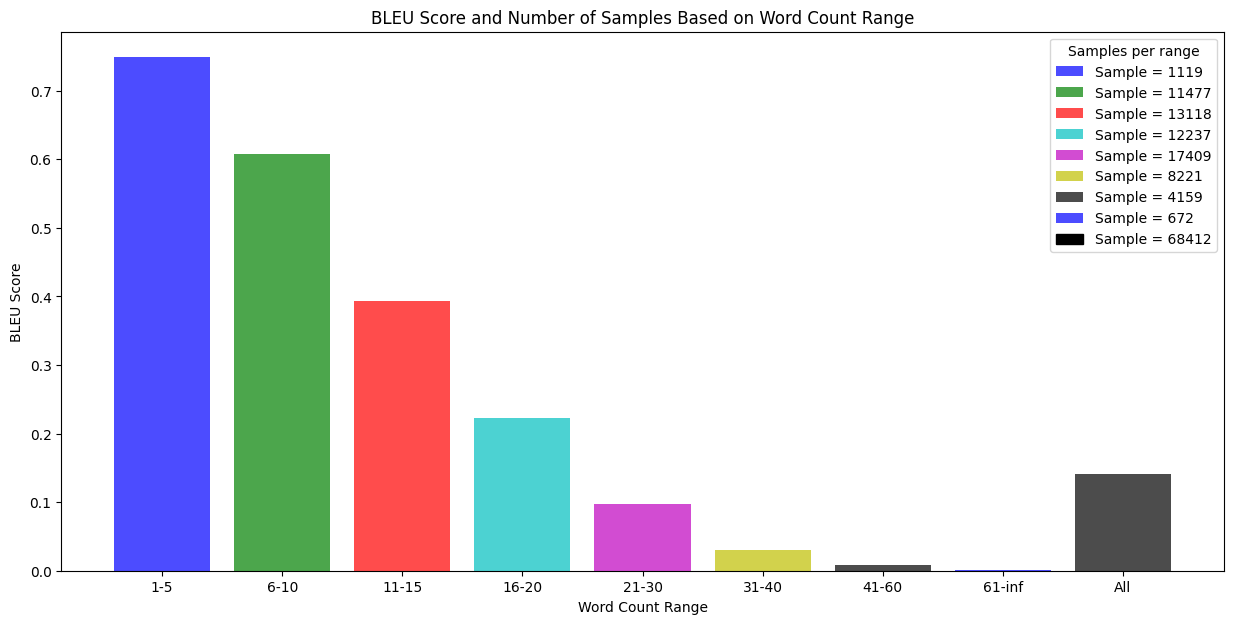

In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 7))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # List of colors for each bar
bar_plot = plt.bar([f'{start}-{end}' for start, end in length_ranges], bleu_scores, color=colors, alpha=0.7, label='BLEU Score')

# Add "All" bar with legend
all_bar = plt.bar("All", bleu_score, color='k', alpha=0.7)

# Create a dummy handle for the "All" bar
all_patch = mpatches.Patch(color='k', label=f'Sample = {tokenized_test_data.num_rows}')

# Add legend for samples per range with corresponding colors
legend_labels = [f'Sample = {value}' for value in samples_per_range]

# Include the dummy handle in the legend
plt.legend(handles=[*bar_plot, all_patch], labels=legend_labels + [f'Sample = {tokenized_test_data.num_rows}'], loc='upper right', title='Samples per range')

plt.xlabel('Word Count Range')
plt.ylabel('BLEU Score')

plt.title('BLEU Score and Number of Samples Based on Word Count Range')

plt.show()
